In [2]:
import pandas as pd
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Base dataset path
base_path = "../data/ds001907"

# ANT event types
cue_types = ['SpatialCue', 'CenterCue', 'NoCue']
target_types = ['Congruent', 'Incongruent']

In [7]:
def load_all_subjects_refined(base_path):
    all_subjects = []
    subs = sorted([s for s in os.listdir(base_path) if s.startswith("sub-")])
    for sub in tqdm(subs, desc="Loading subjects"):
        sub_events = []
        for ses in ["ses-1", "ses-2"]:
            ses_path = os.path.join(base_path, sub, ses, "func")
            if not os.path.exists(ses_path):
                continue
                
            for file in os.listdir(ses_path):
                if file.endswith("_events.tsv"):
                    run = file.split("_run-")[1].split("_")[0] if "_run-" in file else "1"
                    df = pd.read_csv(os.path.join(ses_path, file), sep="\t")
                    df["subject"], df["session"], df["run"] = sub, ses, run
                    
                    # Pair each target with nearest preceding cue (<3 s apart)
                    cues = df[df["trial_type"].isin(cue_types)][["onset", "trial_type"]]
                    targets = df[df["trial_type"].isin(target_types)].copy()
                    targets["prev_trial_type"] = None
                    
                    for i, trow in targets.iterrows():
                        valid_cues = cues[cues["onset"] < trow["onset"]]
                        if not valid_cues.empty:
                            cue = valid_cues.iloc[-1]
                            if trow["onset"] - cue["onset"] < 3.0:
                                targets.at[i, "prev_trial_type"] = cue["trial_type"]
                    
                    sub_events.append(targets.dropna(subset=["prev_trial_type"]))
        if sub_events:
            all_subjects.append(pd.concat(sub_events, ignore_index=True))
    return pd.concat(all_subjects, ignore_index=True)

In [8]:
group_df = load_all_subjects_refined(base_path)
print(f"\nLoaded {group_df['subject'].nunique()} subjects, {len(group_df)} total trials")
display(group_df.head())

Loading subjects:   0%|          | 0/46 [00:00<?, ?it/s]

Loading subjects: 100%|██████████| 46/46 [00:20<00:00,  2.26it/s]


Loaded 46 subjects, 13236 total trials


,onset,duration,trial_type,trial_type_err,response_time,accuracy,target_dir,target_pos,correct_resp,resp,subject,session,run,prev_trial_type
0,26.293,2.0,Congruent,Congruent,610.0,1.0,Left,Up,y,y,sub-RC4101,ses-1,2,NoCue
1,42.551,2.0,Incongruent,Incongruent,641.0,1.0,Right,Down,g,g,sub-RC4101,ses-1,2,SpatialCue
2,66.306,2.0,Congruent,Congruent,519.0,1.0,Right,Up,g,g,sub-RC4101,ses-1,2,NoCue
3,70.304,2.0,Congruent,Congruent,552.0,1.0,Left,Up,y,y,sub-RC4101,ses-1,2,SpatialCue
4,75.052,2.0,Incongruent,TargetErr,601.0,0.0,Left,Down,y,g,sub-RC4101,ses-1,2,NoCue


In [9]:
# Assign groups based on subject IDs
def get_group(sub_id):
    if "RC41" in sub_id:
        return "Healthy"
    elif "RC42" in sub_id:
        return "Parkinson"
    else:
        return "Unknown"

# Apply to dataframe
group_df["group"] = group_df["subject"].apply(get_group)
print(group_df["group"].value_counts())

group
Healthy      7191
Parkinson    6045
Name: count, dtype: int64


In [10]:
valid_cues = ["SpatialCue", "CenterCue", "NoCue"]
valid_targets = ["Congruent", "Incongruent"]

model_df = group_df[
    (group_df["trial_type"].isin(valid_targets)) &
    (group_df["prev_trial_type"].isin(valid_cues)) &
    (group_df["response_time"].between(200, 2000))
].copy()

# Keep relevant columns + group
model_df = model_df[[
    "response_time", "trial_type", "prev_trial_type",
    "target_dir", "target_pos", "session", "run",
    "subject", "group"
]]

# One-hot encode categorical variables (including group)
categorical_cols = [
    "trial_type", "prev_trial_type",
    "target_dir", "target_pos",
    "session", "run", "group"
]
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# Z-score RT per subject
model_df["rt_zscore"] = (
    model_df.groupby("subject")["response_time"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

In [13]:
X = model_df.drop(columns=["response_time", "subject", "rt_zscore"])
y = model_df["rt_zscore"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# Define output path
save_dir = "../data/processed"
os.makedirs(save_dir, exist_ok=True)

# Save as CSV
X_train.to_csv(os.path.join(save_dir, "X_train.csv"), index=False)
y_train.to_csv(os.path.join(save_dir, "y_train.csv"), index=False)
X_test.to_csv(os.path.join(save_dir, "X_test.csv"), index=False)
y_test.to_csv(os.path.join(save_dir, "y_test.csv"), index=False)

# Save column names for reference
with open(os.path.join(save_dir, "feature_columns.txt"), "w") as f:
    for col in X_train.columns:
        f.write(col + "\n")

print("✅ Preprocessed datasets saved to:", save_dir)

✅ Preprocessed datasets saved to: ../data/processed


In [16]:
save_path = os.path.join(save_dir, "ant_behavioral_train_test.pkl")

with open(save_path, "wb") as f:
    pickle.dump({
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }, f)

print("✅ Saved combined pickle file:", save_path)

✅ Saved combined pickle file: ../data/processed/ant_behavioral_train_test.pkl


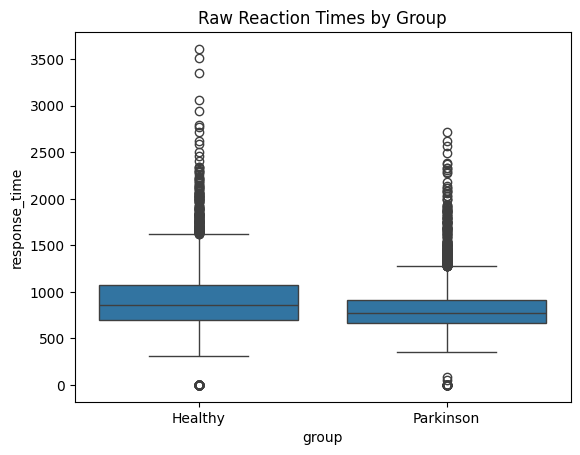

In [12]:
sns.boxplot(data=group_df, x="group", y="response_time")
plt.title("Raw Reaction Times by Group")
plt.show()